# Process Results for PDE Koopman Autoencoder

In [1]:
import json
import matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
 
from architecture.RelMSE import RelMSE

# Set plotting parameters
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

In [2]:
# Set data files and expt name

# If processing Burgers' equation results, uncomment these four lines
#data_file_prefix = './data/Burgers_Eqn'
#expt_name = "Burgers_Expt"
#L = 2 * np.pi
#dt = 0.002

# If processing KS equation results, uncomment these four lines
data_file_prefix = './data/KS_Eqn'
expt_name = "KS_Expt"
L = 8 * np.pi
dt = 0.125

# These are the same for both data sets
n = 128
n_time = 51
num_shifts = 50

In [3]:
# Define functions

def stack_predictions(data, num_shifts):
    """Stack inputs for linearity or prediction loss."""
    len_pred = data.shape[1] - num_shifts
    prediction_list = []
    for j in range(num_shifts):
        prediction_list.append(data[:, j + 1:j + 1 + len_pred, :])
    prediction_tensor = np.concatenate(prediction_list, axis=1)

    return prediction_tensor

def compute_rolling_average(x, window=6):
    if window % 2 != 0:
        raise ValueError("Window must be even.")
        return 1
    # Prepare a copy of the data
    x = x.copy().flatten()
    
    # Create an empty array for storing shifted copies of the data
    mean_array = np.ndarray((x.shape[0], int(window)))

    for i in range(int(window)):
        mean_array[:,i] = np.roll(x, i)

    half_window = int(window/2)
    roll_avg = np.mean(mean_array, axis=1)
    roll_avg = roll_avg[half_window:]
    
    return roll_avg


from matplotlib.collections import LineCollection

# Waterfall plot function
# This is adapted from the answer by OriolAbril at https://stackoverflow.com/questions/11209646/waterfall-plot-python
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    ax.auto_scale_xyz(X,Y,Z) # set axis limits

In [4]:
# Load the model
save_prefix = 'results/{}/'.format(expt_name)
full_model = tf.keras.models.load_model(save_prefix + "final_model", 
                                        custom_objects={"RelMSE": RelMSE})

In [5]:
# Load the data
data_val = np.load('{}_val_x.npy'.format(data_file_prefix))

data_test1 = np.load('{}_test1_x.npy'.format(data_file_prefix))
data_test2 = np.load('{}_test2_x.npy'.format(data_file_prefix))
data_test3 = np.load('{}_test3_x.npy'.format(data_file_prefix))
data_test4 = np.load('{}_test4_x.npy'.format(data_file_prefix))
data_test5 = np.load('{}_test5_x.npy'.format(data_file_prefix))
data_test_all = np.vstack([data_test1, data_test2, data_test3, data_test4, data_test5])

## Get losses for the different datasets

In [6]:
for dset, dtype in zip((data_val, data_test1, data_test2, data_test3, data_test4, data_test5),
                        ['validation', 'white noise test', 'sine wave test', 
                         'square wave test', 'Gaussian test', 'traingle wave test']):
    dset_pred = stack_predictions(dset, num_shifts)
    losses = full_model.evaluate(x=dset, y=[dset, dset, dset_pred], batch_size=32, return_dict=True, verbose=0)
    print("Losses for {} data:".format(dtype))
    print(['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss'])
    for loss in losses:
        print(losses[loss], end=", ")
    print("\n")

Losses for validation data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.007380883675068617, 0.006404772400856018, 0.0001356664433842525, 0.0007605794235132635, 

Losses for white noise test data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.017889872193336487, 0.016801126301288605, 0.0001429429539712146, 0.0008659336599521339, 

Losses for sine wave test data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.0012954940320923924, 0.0004302037414163351, 0.0001384630595566705, 0.0006469623767770827, 

Losses for square wave test data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.0028697808738797903, 0.0019231387414038181, 0.0001283139135921374, 0.0007384633063338697, 

Losses for Gaussian test data:
['Total Loss', 'Autoencoder Loss', 'Outer Autoencoder Loss', 'Prediction Loss']
0.006407293491065502, 0.0022643133997917175, 0.00011734425061149523, 

## Plot prediction from test data

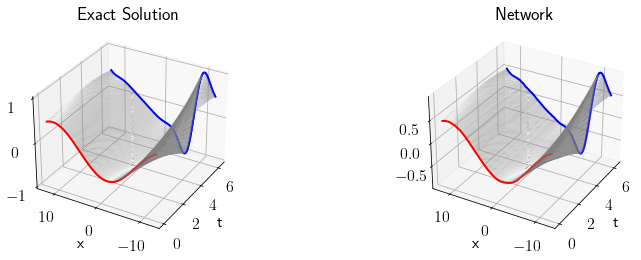

relative MSE:  0.0003672695


In [7]:
"""
Choose an example from the test data (0-4999)

0-999 are white noise initial conditions
1000-1999 are sine wave initial conditions
2000-2999 are square wave initial conditions
3000-3999 are Gaussian initial conditions
4000-4999 are triangle wave initial conditions
"""
ex_num = 1300 


# Exact solution (from test data set)
data = data_test_all
exact = data[ex_num, :, :]

# Predicted solution (from network)
auto_output, outer_auto_output, predictions = full_model.predict(x=data)
network_pred = np.concatenate((auto_output[ex_num, 0:1, :], predictions[ex_num, :, :]), axis=0)

# Set grid for plotting
x_pts = np.linspace(-L / 2, L / 2, n + 1)
x_pts = x_pts[0:n]
t_pts = np.linspace(0, dt * (n_time - 1), n_time)
T, X = np.meshgrid(t_pts, x_pts)


fig = plt.figure(figsize=(13, 4)) 

# Plot "exact" solution from data
ax = fig.add_subplot(1, 2, 1, projection='3d')
waterfall_plot(fig, ax, T, X, np.transpose(exact), time_in=0, time_out=n_time-1, linewidth=2, alpha=.5) 
ax.plot(T[:, 0], X[:, 0], exact[0, :], '-r', linewidth=2)
ax.plot(T[:,-1], X[:,-1], exact[-1,:], '-b', linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

# Plot predicted solution from network
ax = fig.add_subplot(1, 2, 2, projection='3d')
waterfall_plot(fig, ax, T, X, np.transpose(network_pred), time_in=0, time_out=n_time-1, linewidth=2, alpha=.5) 
ax.plot(T[:, 0], X[:, 0], network_pred[0, :], '-r', linewidth=2)
ax.plot(T[:, -1], X[:, -1], network_pred[-1, :], '-b', linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize=18)

plt.show() 

print("relative MSE: ", RelMSE()(exact, network_pred).numpy())

## Plot training losses

In [8]:
# Load results from training
results_path = save_prefix + "initial_pool_results.json"
init_results = json.load(open(results_path))

results_path = save_prefix + "final_model_history.json"
final_results = json.load(open(results_path))

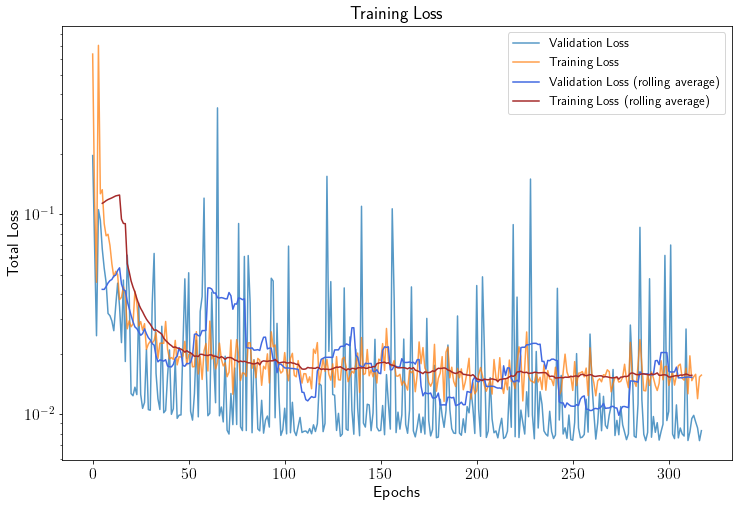

In [9]:
# Plot losses
best_model_idc = np.argmin(init_results['best_loss'])

train_loss = init_results['aec_hist'][best_model_idc]['loss'] + init_results['full_hist'][best_model_idc]['loss'] + final_results['loss']
val_loss = init_results['aec_hist'][best_model_idc]['val_loss'] + init_results['full_hist'][best_model_idc]['val_loss'] + final_results['val_loss']

train_loss = np.asarray(train_loss)
val_loss = np.asarray(val_loss)

roll_window = 20
train_roll = compute_rolling_average(train_loss, window=roll_window)
val_roll = compute_rolling_average(val_loss, window=roll_window)
roll_idcs = np.arange(train_loss.shape[0])[int(roll_window/4):-int(roll_window/4)]

plt.figure()

plt.semilogy(val_loss, label="Validation Loss", alpha=0.75)
plt.semilogy(train_loss, label="Training Loss", alpha=0.75)

plt.semilogy(roll_idcs, val_roll, color='royalblue', label="Validation Loss (rolling average)")
plt.semilogy(roll_idcs, train_roll, color='brown', label="Training Loss (rolling average)")

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend(loc='upper right')

plt.show()